<a href="https://colab.research.google.com/github/Daniel-Francisco-Calderon-Lebro/Vision_por_Computador_con_IA/blob/main/Auto_encoder_entrenador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input,Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os
import random
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import keras
import tensorflow

In [4]:
print(keras.__version__)
print(tensorflow.__version__)

2.15.0
2.15.0


In [5]:
base_path = '/content/drive/MyDrive/Carpeta Parcial 1 VISION IA/'
folder = 'Encoder/'
subfolders = ['Parte_2Noisy' , 'Parte_2Gtruth']

data = []
labels = []
for subfolder in subfolders:
  files = [f for f in os.listdir(base_path + folder + subfolder) if f.endswith('.png')]
  # print(subfolder)
  # print(files)
  # print(len(files))
  for file in files:
    img = cv2.imread(base_path + folder + subfolder + '/' + file, 0)
    img = img.astype('float32') / 255.0
    # img = cv2.resize(img, (128, 128))
    data.append(img)
    labels.append(subfolder)

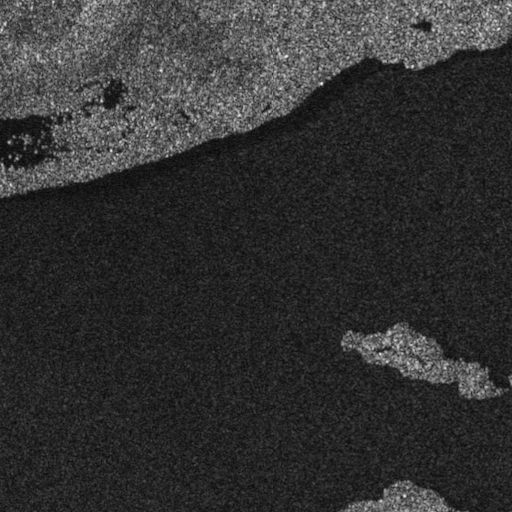

Parte_2Noisy
(512, 512)
2156


In [6]:
pos = random.randint(0, len(data))
cv2_imshow(data[pos]*255)
print(labels[pos])
print(data[pos].shape)

print(len(data))

In [7]:
# encode the labels, converting them from strings to integers
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [8]:
print(labels)

[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]


In [9]:
# perform a training and testing split, using 75% of the data for
# training and 25% for evaluation
(trainX, testX, trainY, testY) = train_test_split(np.array(data), np.array(labels), test_size=0.25)

In [12]:
# Definimos la arquitectura del Autoencoder
autoencoder = Sequential()

# --- Encoder
# Capa de entrada
autoencoder.add(Input(shape=(512, 512, 1)))  # Imagen de entrada en escala de grises de tamaño 512x512x1

# Primera capa convolucional + MaxPooling
autoencoder.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
autoencoder.add(MaxPooling2D((2, 2), padding="same"))  # Reducción a 256x256x32
# Segunda capa convolucional + MaxPooling
autoencoder.add(Conv2D(32, (3, 3), activation="relu", padding="same"))


autoencoder.add(MaxPooling2D((2, 2), padding="same"))  # Reducción a 256x256x32

# --- Decoder


# Primera capa de UpSampling
autoencoder.add(Conv2DTranspose(32, (3, 3), strides=2 ,activation="relu", padding="same"))
autoencoder.add(Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"))

# # Capa de salida - Restaura la imagen al tamaño original (512x512x1)
autoencoder.add(Conv2D(1, (3, 3), activation="sigmoid", padding="same"))

# Resumen del modelo
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 512, 512, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 256, 256, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 256, 256, 32)      9248      
 Transpose)                                                      
                                                      

In [14]:
opt = RMSprop(learning_rate=1e-3)
autoencoder.compile(loss="mean_squared_error", optimizer=opt, metrics=["accuracy"])
H = autoencoder.fit(trainX, trainX, validation_data=(testX, testX), epochs=3, batch_size=1)


Epoch 1/3
1617/1617 [==============================] - 583s 360ms/step - loss: 0.0071 - accuracy: 0.0554 - val_loss: 0.0036 - val_accuracy: 0.0646
Epoch 2/3
1617/1617 [==============================] - 573s 354ms/step - loss: 0.0039 - accuracy: 0.0555 - val_loss: 0.0028 - val_accuracy: 0.0646
Epoch 3/3
1617/1617 [==============================] - 572s 354ms/step - loss: 0.0032 - accuracy: 0.0555 - val_loss: 0.0025 - val_accuracy: 0.0646


In [15]:
# Define la ruta donde quieres guardar el modelo
model_save_path = '/content/drive/MyDrive/Carpeta Parcial 1 VISION IA/Encoder/autoencoder_Daniel_model.h5'

# Verifica si la carpeta existe, si no, crea la carpeta
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Guarda el modelo
autoencoder.save(model_save_path)
# Carga el modelo
autoencoder = load_model(model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Modelo Entrenado con mis Datos

17/17 [==============================] - 19s 1s/step


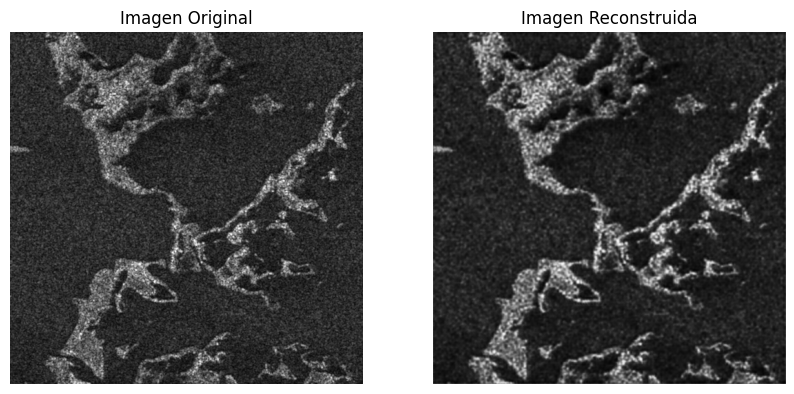

In [16]:

# Realiza predicciones con el modelo
predicted_images = autoencoder.predict(testX)

#  Supongamos que quieres visualizar la primera imagen
index = 0
original_image = testX[index].reshape(512, 512)  # Reestructura si es necesario
predicted_image = predicted_images[index].reshape(512, 512)

plt.figure(figsize=(10, 5))

# Original
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Imagen Original')
plt.axis('off')

# Reconstruida
plt.subplot(1, 2, 2)
plt.imshow(predicted_image, cmap='gray')
plt.title('Imagen Reconstruida')
plt.axis('off')

plt.show()

# Modelo Conseguido desde internet


In [17]:
# Define la ruta donde está guardado el modelo
model_path = '/content/drive/MyDrive/Carpeta Parcial 1 VISION IA/Encoder/Autoencoder_despeckling.h5'

# Carga el modelo
autoencoder = load_model(model_path)

17/17 [==============================] - 25s 1s/step


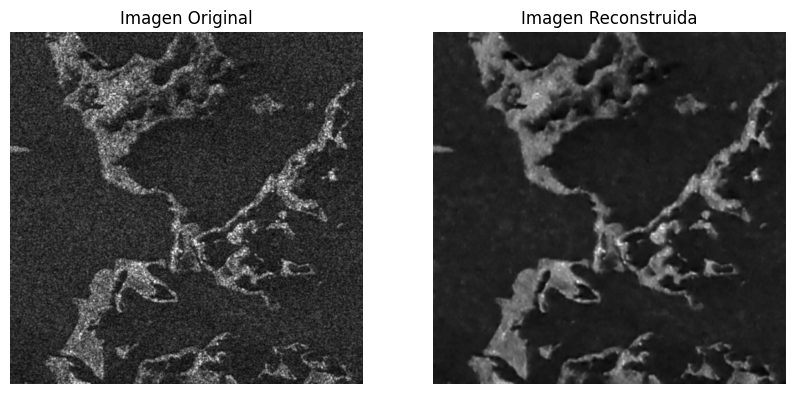

In [18]:
# Realiza predicciones con el modelo
predicted_images = autoencoder.predict(testX)

#  Supongamos que quieres visualizar la primera imagen
index = 0
original_image = testX[index].reshape(512, 512)  # Reestructura si es necesario
predicted_image = predicted_images[index].reshape(512, 512)

plt.figure(figsize=(10, 5))

# Original
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Imagen Original')
plt.axis('off')

# Reconstruida
plt.subplot(1, 2, 2)
plt.imshow(predicted_image, cmap='gray')
plt.title('Imagen Reconstruida')
plt.axis('off')

plt.show()